### Importing the Libraries

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [38]:
tf.__version__ 

'2.15.0'

### Part 1 - Data Preprocessing

#### Generating images for the Training set

In [39]:
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    horizontal_flip = True)

#### Generating images for the Test set

In [40]:
# test_datagen = ImageDataGenerator(rescale = 1./255)

In [41]:
def preprocess_image(image_path):
    # Read the image in grayscale
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Convert the grayscale image to a 3-channel image
    rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    
    # Resize the image to the target size
    rgb_image = cv2.resize(rgb_image, (128, 128))
    
    return rgb_image

# Custom data generator to preprocess images on the fly
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = []
        batch_y = []

        for i, j in enumerate(index_array):
            image_path = self.filepaths[j]
            label = self.labels[j]

            # Preprocess the image (convert grayscale to RGB)
            image = preprocess_image(image_path)
            
            batch_x.append(image)
            batch_y.append(label)

        return np.array(batch_x), np.array(batch_y)

# Create data generators, excluding 'J' and 'Z'
train_datagen = CustomImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
test_datagen = CustomImageDataGenerator(rescale = 1./255)

### Creating the Training set

In [42]:
training_set = train_datagen.flow_from_directory('D:/slr - 1 - Copy/dataSet/trainingData',                                
                                                 target_size = (224,224),
                                                 batch_size = 16,
                                                    
                                                 class_mode = 'categorical',
                                                 shuffle=True)


Found 12036 images belonging to 25 classes.


In [43]:
test_set = test_datagen.flow_from_directory('D:/slr - 1 - Copy/dataSet/testingData',
                                            target_size = (224, 224),                                  
                                            batch_size = 16,        
                                        
                                            class_mode = 'categorical', 
                                            shuffle=False)

Found 6525 images belonging to 25 classes.


In [44]:
class_indices = training_set.class_indices
print("Class indices:", class_indices)

Class indices: {'0': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24}


### Part 2 - Building the CNN

#### Initializing the CNN

In [45]:
# classifier = tf.keras.models.Sequential()

#### Step 1 - Convolution

In [46]:
# classifier.add(tf.keras.layers.Conv2D(filters=32,
#                                      kernel_size=3, 
#                                      padding="same", 
#                                      activation="relu", 
                                    #  input_shape=[128, 128, 1]))

#### Step 2 - Pooling

In [47]:
# classifier.add(tf.keras.layers.MaxPool2D(pool_size=2, 
#                                          strides=2, 
#                                          padding='valid'))

#### Adding a second convolutional layer

In [48]:
# classifier.add(tf.keras.layers.Conv2D(filters=32, 
#                                       kernel_size=3, 
#                                       padding="same", 
#                                       activation="relu"))

# classifier.add(tf.keras.layers.MaxPool2D(pool_size=2, 
#                                          strides=2, 
#                                          padding='valid'))

#### Step 3 - Flattening

In [49]:
# classifier.add(tf.keras.layers.Flatten())

#### Step 4 - Full Connection

In [50]:
# from tensorflow.keras.regularizers import l2
# classifier.add(tf.keras.layers.Dense(units=128, 
#                                      activation='relu',  kernel_regularizer=l2(0.001)))

# classifier.add(tf.keras.layers.Dropout(0.50))
# classifier.add(tf.keras.layers.Dense(units=96, activation='relu',   kernel_regularizer=l2(0.001)))
# classifier.add(tf.keras.layers.Dropout(0.50))
# classifier.add(tf.keras.layers.Dense(units=64, activation='relu',  kernel_regularizer=l2(0.001)))
# classifier.add(tf.keras.layers.Dense(units=25, activation='softmax')) # softmax for more than 2
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Choose your model (e.g., MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
classifier = tf.keras.Sequential([
    base_model,
    # Flatten(),
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')  # Assuming 25 classes for letters
])


### Part 3 - Training the CNN

#### Compiling the CNN

In [51]:
classifier.compile(optimizer = 'adam', 
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

#### Training the CNN on the Training set and evaluating it on the Test set

In [52]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 25)                3225      
                                                                 
Total params: 2425177 (9.25 MB)
Trainable params: 1671

In [53]:
# classifier.fit(training_set,
#                   epochs = 8,
#                   validation_data = test_set)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with callbacks
history = classifier.fit(training_set,
                    epochs=30,  # Increase the number of epochs
                    validation_data=test_set,
                    callbacks=[reduce_lr, early_stopping])
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy}")
print(f"Final Validation Accuracy: {final_validation_accuracy}")

Epoch 1/30
753/753 [==============================] - 786s 1s/step - loss: 0.3345 - accuracy: 0.9155 - val_loss: 0.3004 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 2/30
753/753 [==============================] - 697s 925ms/step - loss: 0.0343 - accuracy: 0.9926 - val_loss: 0.2231 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 3/30
753/753 [==============================] - 907s 1s/step - loss: 0.0206 - accuracy: 0.9954 - val_loss: 0.2476 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 4/30
753/753 [==============================] - 1016s 1s/step - loss: 0.0173 - accuracy: 0.9957 - val_loss: 0.2601 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 5/30
753/753 [==============================] - 1214s 2s/step - loss: 0.0285 - accuracy: 0.9910 - val_loss: 0.2156 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 6/30
753/753 [==============================] - 812s 1s/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.3995 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 7/30
753/753 [==============================] - 630s 

#### Saving the Model

In [54]:
model_json = classifier.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')
classifier.save_weights('model_new.h5')
print('Weights saved')

Model Saved
Weights saved


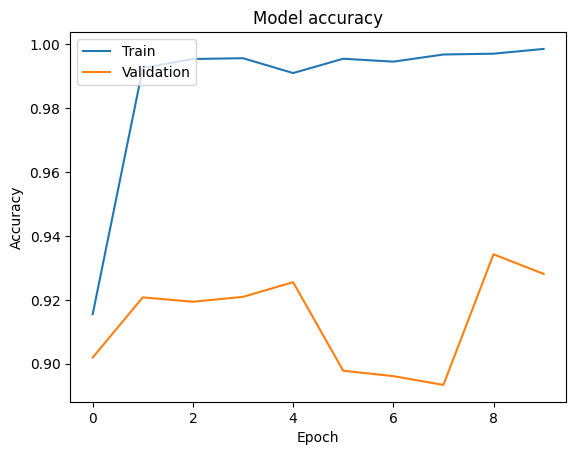

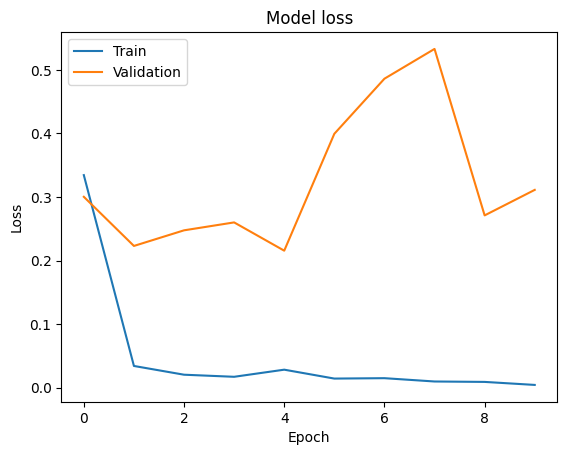

In [55]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [56]:
import numpy as np

y_pred = classifier.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes


408/408 [==============================] - 210s 509ms/step


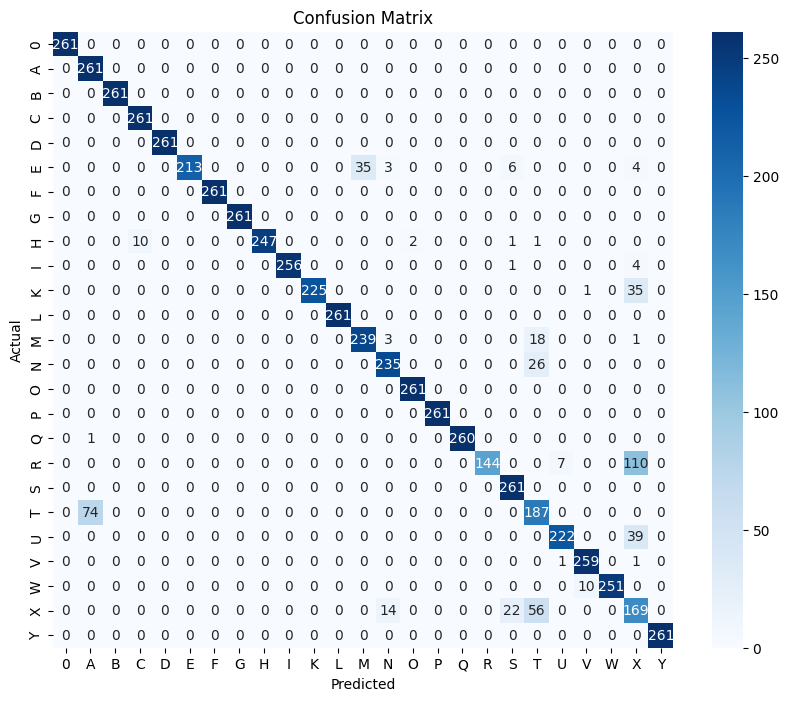

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       261
           1       0.78      1.00      0.87       261
           2       1.00      1.00      1.00       261
           3       0.96      1.00      0.98       261
           4       1.00      1.00      1.00       261
           5       1.00      0.82      0.90       261
           6       1.00      1.00      1.00       261
           7       1.00      1.00      1.00       261
           8       1.00      0.95      0.97       261
           9       1.00      0.98      0.99       261
          10       1.00      0.86      0.93       261
          11       1.00      1.00      1.00       261
          12       0.87      0.92      0.89       261
          13       0.92      0.90      0.91       261
          14       0.99      1.00      1.00       261
          15       1.00      1.00      1.00       261
          16       1.00      1.00      1.00       261
          17       1.00    